<a href="https://colab.research.google.com/github/urvog/weatherclassification/blob/main/WeatherClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather Classification

Project: Weather Image Classifer

## 01 - Importing Weather Data Set

Multi-class weather dataset(MWD) for image classification is a valuable dataset used in the research paper entitled “Multi-class weather recognition from still image using heterogeneous ensemble method”. The dataset provides a platform for outdoor weather analysis by extracting various features for recognizing different weather conditions. 

URL:
https://data.mendeley.com/datasets/4drtyfjtfy/1

In [ ]:
COLAB = True
#!wget https://drive.google.com/file/d/1iNe2qfXzp5PUmnDFPDWlpxgqQAagtB_i/

In [2]:
#unzip data
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/training/
   creating: dataset/training/cloudy/
  inflating: dataset/training/cloudy/cloudy1.jpg  
  inflating: dataset/training/cloudy/cloudy10.jpg  
  inflating: dataset/training/cloudy/cloudy100.jpg  
  inflating: dataset/training/cloudy/cloudy101.jpg  
  inflating: dataset/training/cloudy/cloudy102.jpg  
  inflating: dataset/training/cloudy/cloudy103.jpg  
  inflating: dataset/training/cloudy/cloudy104.jpg  
  inflating: dataset/training/cloudy/cloudy105.jpg  
  inflating: dataset/training/cloudy/cloudy106.jpg  
  inflating: dataset/training/cloudy/cloudy107.jpg  
  inflating: dataset/training/cloudy/cloudy108.jpg  
  inflating: dataset/training/cloudy/cloudy109.jpg  
  inflating: dataset/training/cloudy/cloudy11.jpg  
  inflating: dataset/training/cloudy/cloudy110.jpg  
  inflating: dataset/training/cloudy/cloudy111.jpg  
  inflating: dataset/training/cloudy/cloudy112.jpg  
  inflating: dataset/training/cloudy/cloudy113.jpg  
  inflating:

In [62]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.python.client import device_lib
from keras.utils.vis_utils import model_to_dot


from IPython.display import SVG
from PIL import Image
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13877202379234521852
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8391498244199048893
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

## 02 - Data Exploration Analysis (EDA)

In this section we will proceed to perform the exploration and analysis of the data.

First, we will proceed to review the structure of the dataset and show some examples of images.


In [33]:
#Lets count all files and show subdirectory structure
totalFiles = 0
totalDir = 0
PATH = 'dataset'

for base, dirs, files in os.walk(PATH):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1
print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Searching in :  dataset
Searching in :  dataset/training
Searching in :  dataset/training/cloudy
Searching in :  dataset/training/shine
Searching in :  dataset/training/sunrise
Searching in :  dataset/training/rain
Searching in :  dataset/validation
Searching in :  dataset/validation/cloudy
Searching in :  dataset/validation/shine
Searching in :  dataset/validation/sunrise
Searching in :  dataset/validation/rain
Total number of files 1125
Total Number of directories 10
Total: 1135


The dataset is composed of images for training, validation and test. The test samples will be used for the final evaluation of the model.

Each subfolder in turn is made up of weather type samples such as: cloudy, shine, sunrise, rain, which are the targets for our ML model.

We have 1125 images samples, and now we will dataset distribution



In [130]:
#Count images samples for each category.

targets = ['cloudy','rain','shine','sunrise']

def count_targets(path_dataset, targets = targets):
  """
  Function to count samples for each category
  input: 
    path_to_dataset - (example, validation, training or test)
    targets - targets from dataset for each category
  output:
    count_target - numpy array with count files for each category
  
  """
  counts_target = []
  for folder in targets:
    path, dirs, files = next(os.walk(path_dataset+folder))
    file_count = len(files)    
    counts_target.append([folder,file_count])
    
  return np.array(counts_target, dtype = object)

train_samples = count_targets(path_dataset = 'dataset/training/')
validation_samples = count_targets(path_dataset = 'dataset/validation/')



Text(0.5, 1.0, 'Training Samples')

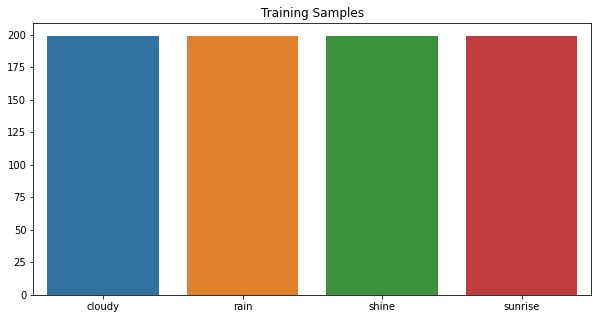

In [131]:
#Let's plot samples distribution for training
fig = plt.figure(figsize = (10,5))
ax = sns.barplot(x = train_samples[:,0], y = train_samples[:,1])
ax.set_title("Training Samples")

Text(0.5, 1.0, 'ValidationSamples')

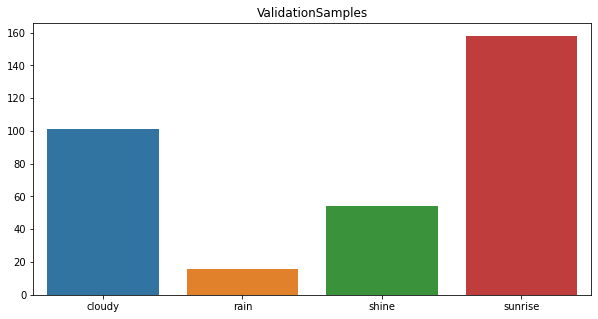

In [132]:
#Let's plot samples distribution for validation
fig = plt.figure(figsize = (10,5))
ax = sns.barplot(x = train_samples[:,0], y = validation_samples[:,1])
ax.set_title("ValidationSamples")

### 02.01 -Images samples

Now we will proceed to show some training samples of the images to see some features


(259, 194)


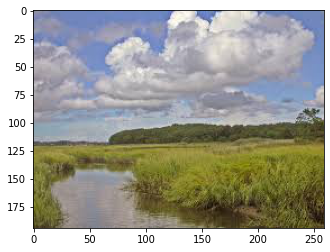

In [137]:
#cloudy
img = Image.open("dataset/training/cloudy/cloudy100.jpg")
print(img.size)
plt.imshow(img)

(259, 194)


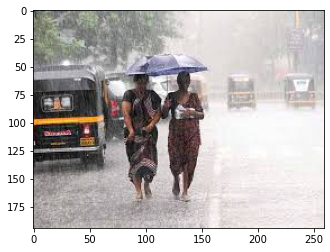

In [138]:
#rain
img = Image.open("dataset/training/rain/rain105.jpg")
print(img.size)
plt.imshow(img)

(278, 181)


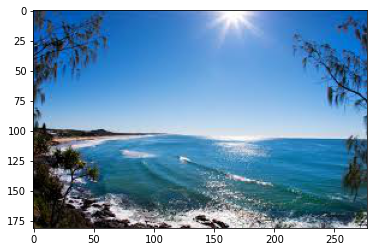

In [139]:
#shine
img = Image.open("dataset/training/shine/shine110.jpg")
print(img.size)
plt.imshow(img)

(299, 169)


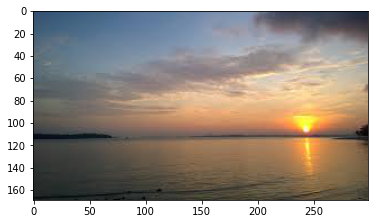

In [140]:
#shine
img = Image.open("dataset/training/sunrise/sunrise115.jpg")
print(img.size)
plt.imshow(img)

## 03 - Image Processing anda Data Augmentation

At this stage we are going to generate images using Keras Generator and then save it in a temporary directory "preview/", in this way we can see how the Data Augmentation strategy is working. We disable rescaling so that images can be easily viewed.

In [143]:
!mkdir preview/
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('dataset/training/rain/rain104.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='rain', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

mkdir: cannot create directory ‘preview/’: File exists


Now it's time to load the dataset with the image generator from Keras. Ee will use the following configurations: rescaling, rotation, shear range, zoom and horizontal flip.

In [145]:
BATCH_SIZE = 32
IMAGE_SIZE = 150

# this is the augmentation configuration we will use just for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
# only for rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only for rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'dataset/training/',  # this is the target directory
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # all images will be resized to 150x150
        batch_size=BATCH_SIZE,
        class_mode='categorical')

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        'dataset/validation/', #this is the validation directory
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 796 images belonging to 4 classes.
Found 329 images belonging to 4 classes.


As shown above, the generators are effectively loaded with the number of samples and categories (targets) identified.

## 04 - Model Implementation

We are now ready to define our model. The strategy for this work is to make two models from scratch and one using transfer learning, in this way we can see the behavior and performance of each one.

### Model 1

In [ ]:
keras.backend.clear_session() #clear model numbers

input_layer = keras.layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))

#CNN - Convolutional Layers
conv_layer = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(input_layer)
conv_layer = keras.layers.Conv2D(16, (3,3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))(conv_layer)

#FC - Fully connected
flatten = keras.layers.Flatten()(pooling_layer)
dense = keras.layers.Dense(200, activation="relu")(flatten)
dropout = keras.layers.Dropout(0.5)(dense)

classifier = keras.layers.Dense(4, activation="softmax")(dropout)

model = keras.Model(inputs=input_layer, outputs=classifier)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 90000)             0         
                                                                 
 dense (Dense)               (None, 200)               18000200  
                                                             

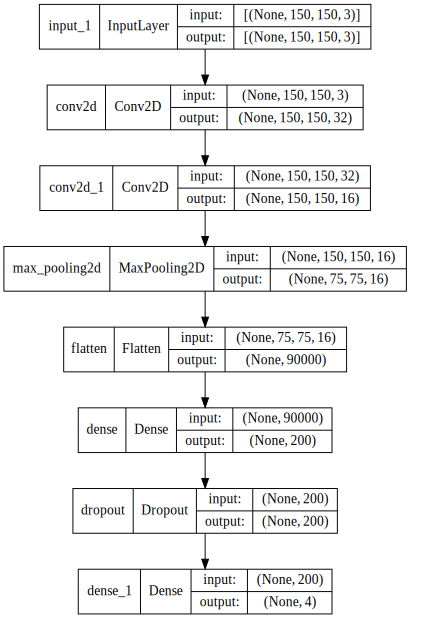

In [ ]:
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=70).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

Visual Simple Model Architecture

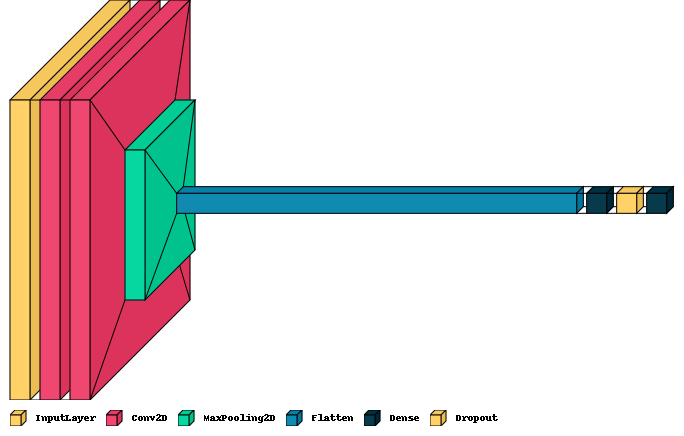

In [ ]:
!pip install visualkeras
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, legend=True,scale_xy=2)

### Model 2

In [ ]:
keras.backend.clear_session() #clear model numbers

input_layer = keras.layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))

#CNN - Convolutional Layers
conv_layer = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(input_layer)
conv_layer = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))(conv_layer)

conv_layer = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(pooling_layer)
conv_layer = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))(conv_layer)

#FC - Fully connected
flatten = keras.layers.Flatten()(pooling_layer)
dense = keras.layers.Dense(200, activation="relu")(flatten)
dropout = keras.layers.Dropout(0.5)(dense)
dense = keras.layers.Dense(100, activation="relu")(dropout)
dropout = keras.layers.Dropout(0.2)(dense)

classifier = keras.layers.Dense(4, activation="softmax")(dropout)

model2 = keras.Model(inputs=input_layer, outputs=classifier)
opt = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss="categorical_crossentropy",metrics=['accuracy'])
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        36928     
                                                             

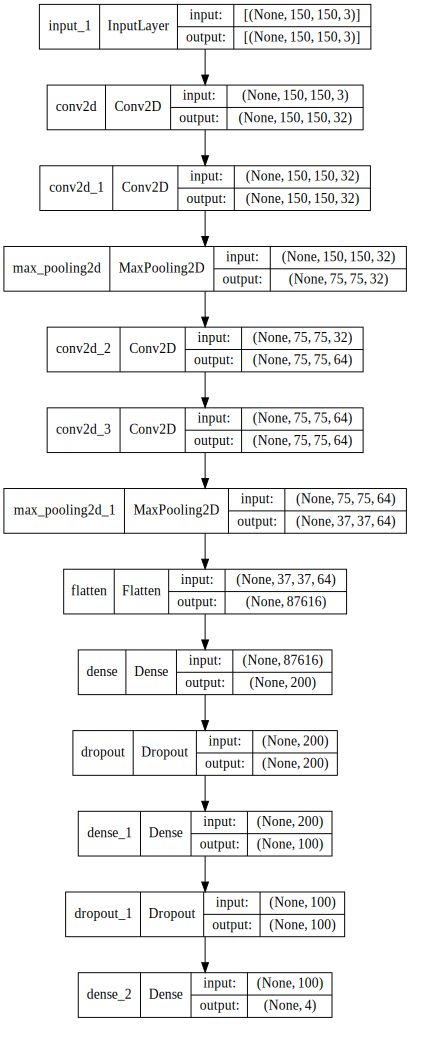

In [ ]:
if COLAB:
    display(SVG(model_to_dot(model2, show_shapes=True,dpi=70).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model2, show_shapes=True).create(prog='dot', format='svg')))

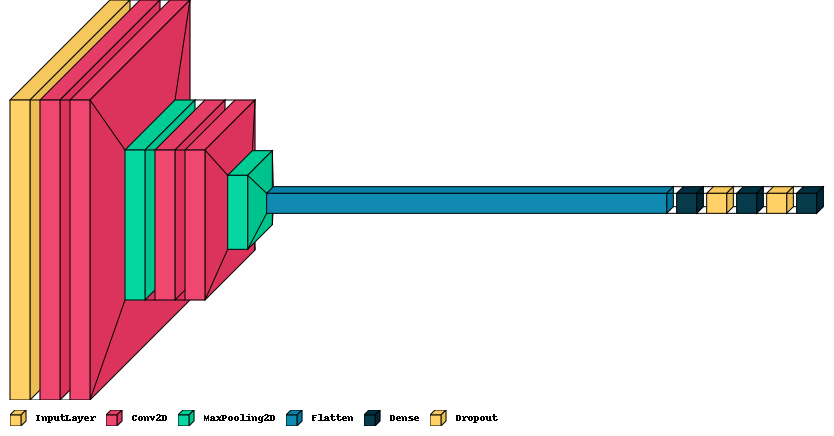

In [ ]:
visualkeras.layered_view(model2).show() # display using your system viewer
visualkeras.layered_view(model2, legend=True,scale_xy=2)

## 05 - Training Model

### Training Model 1

In [ ]:
history1 = model.fit(train_generator,validation_data=validation_generator, epochs=50)

Epoch 1/50
25/25 [==============================] - 11s 400ms/step - loss: 1.3562 - accuracy: 0.5364 - val_loss: 0.6078 - val_accuracy: 0.6778
Epoch 2/50
25/25 [==============================] - 10s 390ms/step - loss: 0.7235 - accuracy: 0.6746 - val_loss: 0.5466 - val_accuracy: 0.7264
Epoch 3/50
25/25 [==============================] - 10s 394ms/step - loss: 0.6296 - accuracy: 0.7249 - val_loss: 0.5576 - val_accuracy: 0.7112
Epoch 4/50
25/25 [==============================] - 10s 398ms/step - loss: 0.5798 - accuracy: 0.7475 - val_loss: 0.5071 - val_accuracy: 0.7812
Epoch 5/50
25/25 [==============================] - 10s 398ms/step - loss: 0.5552 - accuracy: 0.7726 - val_loss: 0.3079 - val_accuracy: 0.9210
Epoch 6/50
25/25 [==============================] - 10s 387ms/step - loss: 0.4612 - accuracy: 0.8166 - val_loss: 0.3983 - val_accuracy: 0.8845
Epoch 7/50
25/25 [==============================] - 10s 388ms/step - loss: 0.4415 - accuracy: 0.8178 - val_loss: 0.5947 - val_accuracy: 0.7812

### Training Model 2

In [ ]:
history2 = model2.fit(train_generator,validation_data=validation_generator, epochs=50)

Epoch 1/50
25/25 [==============================] - 10s 393ms/step - loss: 1.0367 - accuracy: 0.5578 - val_loss: 0.4931 - val_accuracy: 0.7751
Epoch 2/50
25/25 [==============================] - 10s 382ms/step - loss: 0.7668 - accuracy: 0.6771 - val_loss: 0.4912 - val_accuracy: 0.6900
Epoch 3/50
25/25 [==============================] - 10s 384ms/step - loss: 0.6484 - accuracy: 0.7198 - val_loss: 0.5313 - val_accuracy: 0.7508
Epoch 4/50
25/25 [==============================] - 10s 377ms/step - loss: 0.6189 - accuracy: 0.7412 - val_loss: 0.3847 - val_accuracy: 0.8419
Epoch 5/50
25/25 [==============================] - 10s 389ms/step - loss: 0.5622 - accuracy: 0.7889 - val_loss: 0.3779 - val_accuracy: 0.8541
Epoch 6/50
25/25 [==============================] - 10s 388ms/step - loss: 0.4905 - accuracy: 0.8204 - val_loss: 0.4464 - val_accuracy: 0.8267
Epoch 7/50
25/25 [==============================] - 10s 383ms/step - loss: 0.5184 - accuracy: 0.8003 - val_loss: 0.2536 - val_accuracy: 0.9392

## 06 - Loss and Accuracy Plotting

In [ ]:
import matplotlib.pyplot as plt
def plot_curves(history):
  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Error')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['Training', 'Validation'])

  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.legend(['Training', 'Validation'], loc='lower right');

### Plotting Model Performance 1

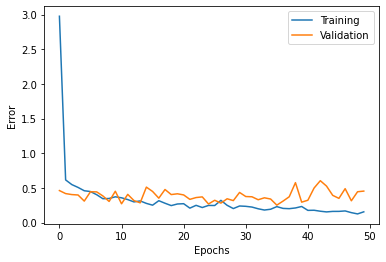

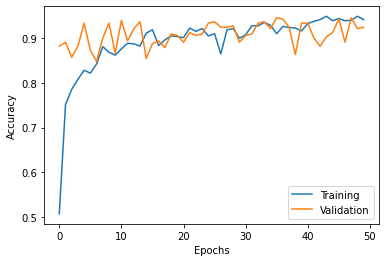

In [ ]:
plot_curves(history1.history)

### Plotting Model Performance 2

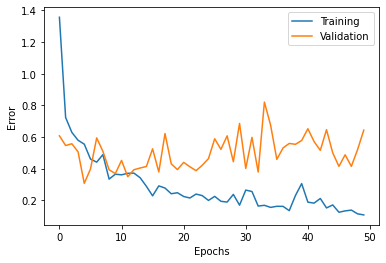

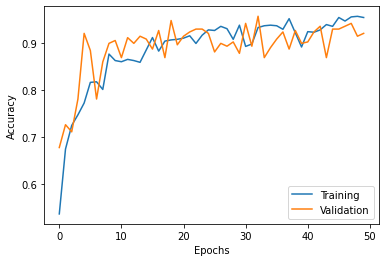

In [ ]:
plot_curves(history1.history)

## 07 - Final Scores

### Scores Model 1

In [ ]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])

25/25 [==============================] - 9s 359ms/step - loss: 0.1102 - accuracy: 0.9535
Train loss    : 0.11019628494977951
Train accuracy: 0.9535176157951355
11/11 [==============================] - 1s 64ms/step - loss: 0.4544 - accuracy: 0.9240
Val loss    : 0.4543999135494232
Val accuracy: 0.9240121841430664


### Scores Model 2

In [ ]:
scores_tr = model2.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])

scores_val = model2.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])

25/25 [==============================] - 9s 350ms/step - loss: 0.0722 - accuracy: 0.9698
Train loss    : 0.07216516882181168
Train accuracy: 0.9698492288589478
11/11 [==============================] - 1s 61ms/step - loss: 0.3845 - accuracy: 0.9392
Val loss    : 0.38449928164482117
Val accuracy: 0.9392096996307373


## 08 - Predictions

In [ ]:
#print classes indices
print(train_generator.class_indices)

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}


In [ ]:
def plot_predictions(model):
  fig = plt.figure(figsize=(20, 7))
  rows = 4
  columns = 2
  c = 1
  for i in range(0,4):
    for j in range(0,2):
      idx_img = np.random.randint(200,220)
      if i == 0:
        path = 'dataset/validation/cloudy/cloudy'+str(idx_img)+'.jpg'
      elif i == 1:
        path ='dataset/validation/rain/rain'+str(idx_img)+'.jpg'
      elif i == 2:
        path ='dataset/validation/shine/shine'+str(idx_img)+'.jpg'
      elif i == 3:
        path ='dataset/validation/sunrise/sunrise'+str(idx_img)+'.jpg'

      fig.add_subplot(rows,columns,c)
      img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
      x=img_to_array(img)
      x=np.expand_dims(x, axis=0)
      images = np.vstack([x])
      classes = model.predict(images)
      str_predict = "Cloudy: {:.2f}%, Rain: {:.2f}%, shine: {:.2f}%, sunrise: {:.2f}% ".format(classes[0][0]*100,classes[0][1]*100,classes[0][2]*100, classes[0][3]*100)
      plt.imshow(img)
      plt.axis('off')
      plt.title(str_predict)
      c+=1

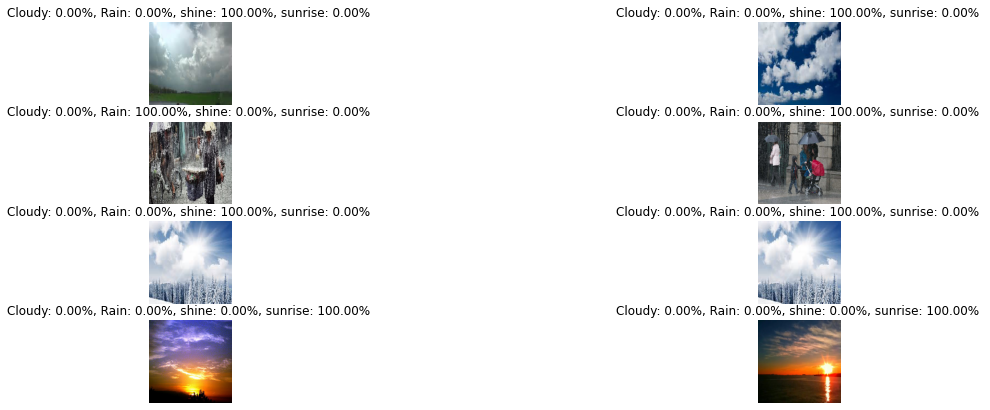

In [ ]:
plot_predictions(model2)

## 09 - Transfer Learning Model

In [ ]:
from tensorflow.keras.applications import VGG16
vgg_base = VGG16(weights='imagenet',    # use weights for ImageNet
                 include_top=False,     # drop the Dense layers!
                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
print(vgg16_base.summary())

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
keras.backend.clear_session() #clear model numbers

for layer in vgg16_base.layers:
    layer.trainable = False
    
model_t = tf.keras.models.Sequential([
        # our vgg16_base model added as a layer
        vgg16_base,
        # here is our custom prediction layer (same as before)
        keras.layers.Flatten(),        
        keras.layers.Dense(200, activation='relu'),        
        keras.layers.Dense(4, activation='softmax')    
    ])

model_t.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_t.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 200)               1638600   
                                                                 
 dense_1 (Dense)             (None, 4)                 804       
                                                                 
Total params: 16,354,092
Trainable params: 1,639,404
Non-trainable params: 14,714,688
_________________________________________________________________


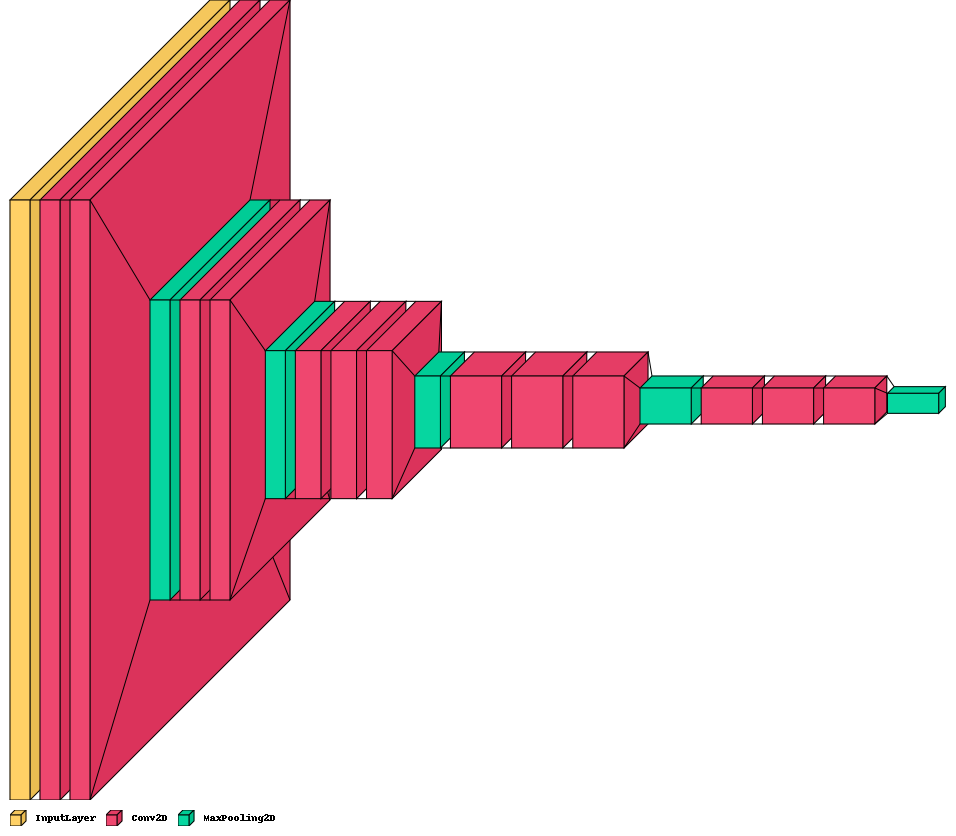

In [ ]:
visualkeras.layered_view(vgg16_base).show() # display using your system viewer
visualkeras.layered_view(vgg16, legend=True,scale_xy=2)

In [ ]:
history2 = model_t.fit(train_generator,validation_data=validation_generator, epochs=50)

Epoch 1/50
25/25 [==============================] - 13s 455ms/step - loss: 0.9536 - accuracy: 0.6633 - val_loss: 0.4376 - val_accuracy: 0.8511
Epoch 2/50
25/25 [==============================] - 10s 395ms/step - loss: 0.3387 - accuracy: 0.8731 - val_loss: 0.3057 - val_accuracy: 0.9027
Epoch 3/50
25/25 [==============================] - 10s 394ms/step - loss: 0.2579 - accuracy: 0.9095 - val_loss: 0.2935 - val_accuracy: 0.9179
Epoch 4/50
25/25 [==============================] - 10s 401ms/step - loss: 0.1802 - accuracy: 0.9309 - val_loss: 0.2061 - val_accuracy: 0.9362
Epoch 5/50
25/25 [==============================] - 10s 394ms/step - loss: 0.1317 - accuracy: 0.9611 - val_loss: 0.2157 - val_accuracy: 0.9362
Epoch 6/50
25/25 [==============================] - 10s 397ms/step - loss: 0.1229 - accuracy: 0.9636 - val_loss: 0.2490 - val_accuracy: 0.9271
Epoch 7/50
25/25 [==============================] - 10s 394ms/step - loss: 0.0988 - accuracy: 0.9648 - val_loss: 0.2246 - val_accuracy: 0.9240

In [ ]:
scores_tr = model_t.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])

scores_val = model_t.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])

25/25 [==============================] - 9s 353ms/step - loss: 0.0137 - accuracy: 0.9962
Train loss    : 0.013691489584743977
Train accuracy: 0.9962311387062073
11/11 [==============================] - 1s 77ms/step - loss: 0.2150 - accuracy: 0.9544
Val loss    : 0.2150276154279709
Val accuracy: 0.954407274723053
